## Try to maximize the likelihood using iminuit (compressed params)

See tutorials here: https://nbviewer.jupyter.org/github/scikit-hep/iminuit/tree/master/tutorial/

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
# our own modules
from lace.data import data_MPGADGET
from lace.emulator import gp_emulator
from lace.emulator import p1d_archive
from lace.likelihood import likelihood
from lace.likelihood import lya_theory
from lace.cosmo import fit_linP
from lace.sampler import iminuit_minimizer
import time

### Note that this minimiser is quite fragile, it only works when starting near the truth
Setup mock data, from one of simulations in the suite

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label='h'
#test_sim_label='central'
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None

In [3]:
# specify simulation suite and P1D mesurements
basedir="/lace/emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
z_max_data=4
data=data_MPGADGET.P1D_MPGADGET(basedir=basedir,
                                skewers_label=skewers_label,
                                sim_label=test_sim_label,
                                zmax=z_max_data,pivot_scalar=0.05)

H0 = 7.4000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.0138E-09, n_s = 9.6756E-01, alpha_s = 0.0000E+00


In [4]:
# get true cosmo in simulation (used below)
sim_cosmo=data.mock_sim.sim_cosmo

Setup archive of P1D measurements from simulations to train the emulator

In [5]:
# Set up emulator training set
z_max_emu=4
archive=p1d_archive.archiveP1D(basedir=basedir,drop_sim_number=drop_sim_number,
                            drop_tau_rescalings=True,z_max=z_max_emu,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [6]:
## Build emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max_emu,
                                verbose=False,paramList=paramList,train=True,
                                asymmetric_kernel=True,rbf_only=True,
                                emu_type="k_bin",passarchive=archive,
                                kmax_Mpc=kmax_Mpc)

 /Users/font/opt/anaconda3/envs/lya_cosmo/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 270 points
Optimised


Setup LyaTheory, explicit in case we don't use any cosmo param and likelihood gets confused

In [7]:
# specify whether to use true cosmology in simulation as fiducial (easier test)
use_sim_fid=False
if use_sim_fid:
    print('use true cosmo as fiducial')
    theory=lya_theory.LyaTheory(zs=data.z,emulator=emu,cosmo_fid=sim_cosmo,use_camb_fz=True)
else:
    theory=lya_theory.LyaTheory(zs=data.z,emulator=emu,use_camb_fz=True)
    print('use default cosmo as fiducial')

use default cosmo as fiducial


In [8]:
# fit linear power parameters for simulation cosmology
sim_linP_params=fit_linP.parameterize_cosmology_kms(cosmo=sim_cosmo,camb_results=None,
                z_star=theory.cosmo.z_star,kp_kms=theory.cosmo.kp_kms)
sim_linP_params

{'f_star': 0.9757637107929042,
 'g_star': 0.9577005129962274,
 'linP_kms': poly1d([-0.10814586, -2.29808459, 16.05813669]),
 'Delta2_star': 0.3478227140323061,
 'n_star': -2.2980845916616803,
 'alpha_star': -0.21629172043452605}

In [9]:
# Likelihood parameters (option to fix cosmology for testing)
fix_cosmo=False
if fix_cosmo:
    assert use_sim_fid,'do you want to fix the cosmology when not using the right one?'
    like_params=["ln_tau_0","ln_sigT_kms_0","ln_gamma_0"]
    like_param_limits=[[-0.2, 0.2],[-0.5, 0.5],[-0.2, 0.2]]
else:
    like_params=["Delta2_star","n_star","ln_tau_0","ln_sigT_kms_0","ln_gamma_0"]
    like_param_limits=[[0.2, 0.5], [-2.4, -2.2], [-0.2, 0.2],
            [-0.5, 0.5], [-0.2, 0.2]]

In [10]:
like=likelihood.Likelihood(data=data,theory=theory,
                            free_param_names=like_params,
                            free_param_limits=like_param_limits,
                            verbose=False,prior_Gauss_rms=0.1)

In [11]:
## Evaluate log_prob at random point in parameter space
theta=np.ones(len(like_params))*0.5 ## Just pick the middle of likelihood space
print('starting point')
for par in like.parameters_from_sampling_point(theta):
    print(par.info_str())
chi2_test=like.get_chi2(theta)
print('starting chi2',chi2_test)

starting point
Delta2_star = 0.35
n_star = -2.3
ln_tau_0 = 0.0
ln_sigT_kms_0 = 0.0
ln_gamma_0 = 0.0
starting chi2 8.13160794522762


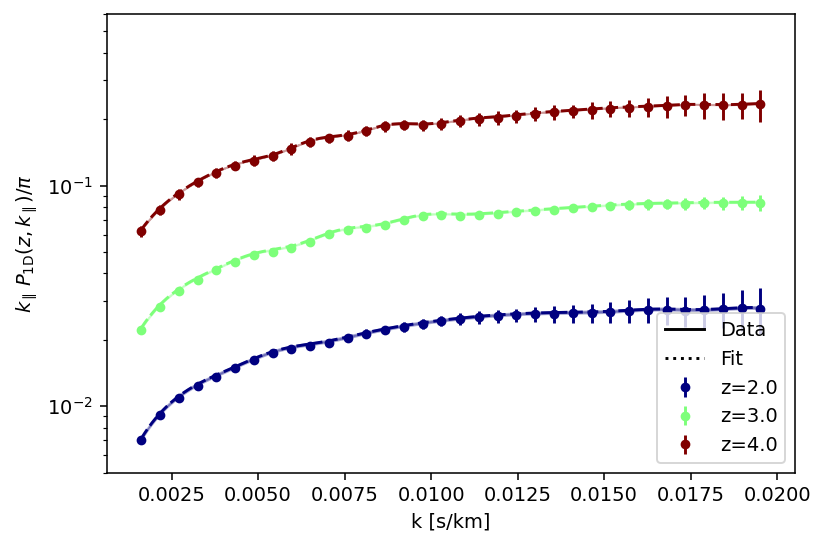

In [12]:
like.plot_p1d(plot_every_iz=4)

### Setup our own minimizer

In [13]:
minimizer = iminuit_minimizer.IminuitMinimizer(like)

In [14]:
minimizer.minimize()

will run migrad
------------------------------------------------------------------
| FCN = -24.29                  |     Ncalls=109 (109 total)     |
| EDM = 7.42e-08 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
will compute Hessian matrix


best-fit values = [0.48670768 0.51511231 0.49209387 0.51458445 0.50865978]


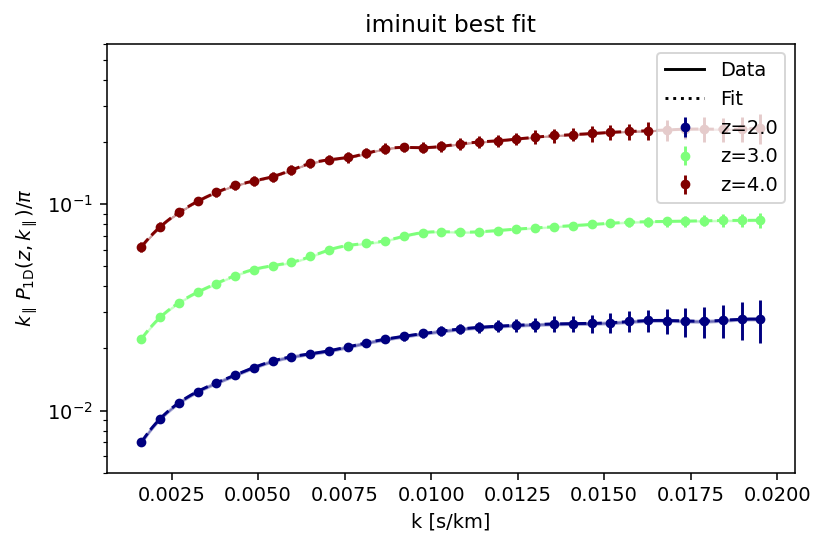

In [15]:
minimizer.plot_best_fit(plot_every_iz=4)

### Plot Gaussian contours after minimization

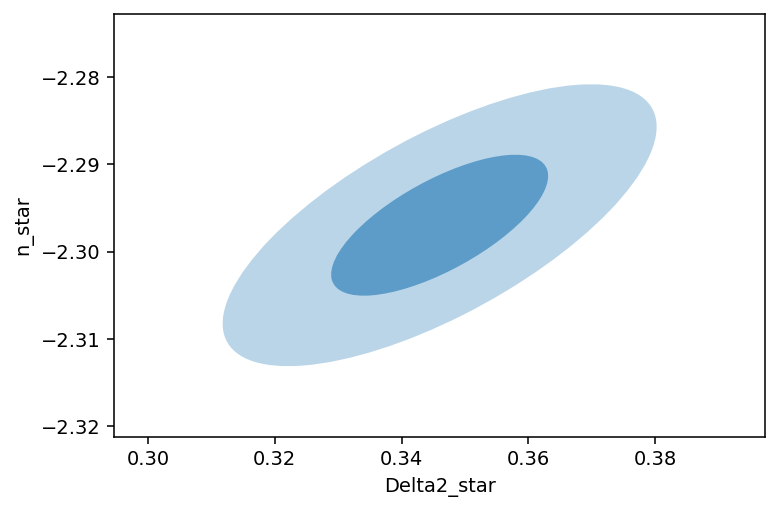

In [16]:
minimizer.plot_ellipses('Delta2_star','n_star',cube_values=False) 

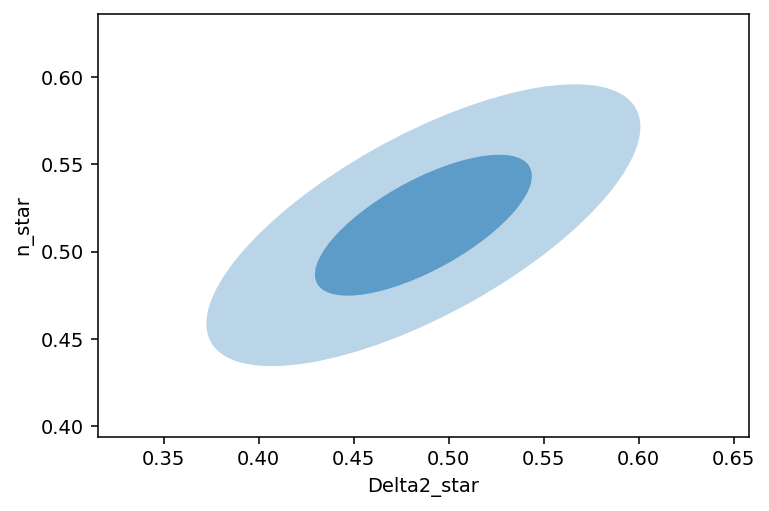

In [17]:
minimizer.plot_ellipses('Delta2_star','n_star',cube_values=True) 

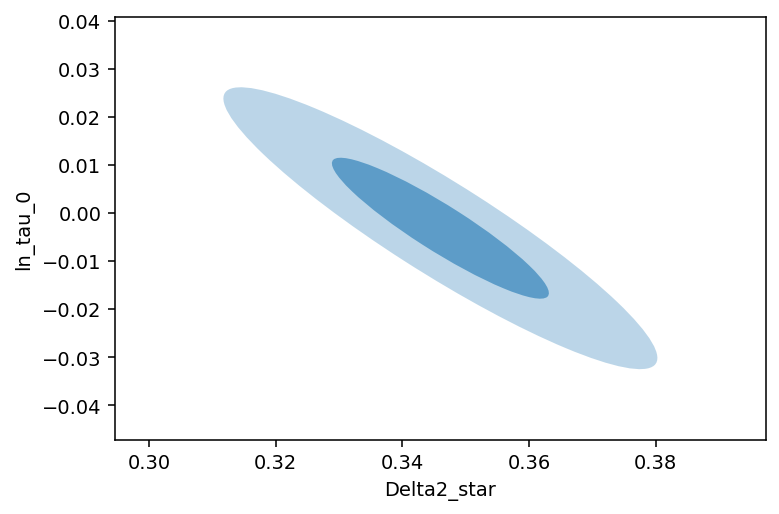

In [18]:
minimizer.plot_ellipses('Delta2_star','ln_tau_0',cube_values=False) 

# Run iminuit minimiser (not using our object)

In [19]:
from iminuit import Minuit

In [20]:
#m = Minuit.from_array_func(like.get_chi2,theta,error=0.1,errordef=1)
m = Minuit.from_array_func(like.minus_log_prob,theta,error=0.02,errordef=0.5)

In [21]:
# run optimiser
m.migrad()

------------------------------------------------------------------
| FCN = -24.29                  |     Ncalls=109 (109 total)     |
| EDM = 7.42e-08 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   0.49    |   0.06    |            |            |         |         |       |
| 1 | x1   |   0.52    |   0.04    |            |            |         |         |       |
| 2 | x2   |   0.49    |   0.04    |            |            |         |         |       |
| 3 | x3   |   0.51    |   0.08    |            |            |         |         |       |
| 4 | x4   |   0.51    |   0.07    |            |            |         |         |       |
------------------------------------------------------------------------------------------

In [22]:
# access results again
print('best fit values =',m.values)
m.get_fmin()

best fit values = <ValueView of Minuit at 7f9b256bffd0>
  x0: 0.48670767704135104
  x1: 0.5151123145759435
  x2: 0.4920938656137791
  x3: 0.5145844504315649
  x4: 0.508659776374107


------------------------------------------------------------------
| FCN = -24.29                  |     Ncalls=109 (109 total)     |
| EDM = 7.42e-08 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------

### Compare to truth

In [23]:
min_chi2=like.get_chi2(m.values)
print('minimum chi2',min_chi2)
for par in like.parameters_from_sampling_point(m.values):
    print(par.info_str())

minimum chi2 0.5534904291889808
Delta2_star = 0.34601230311240533
n_star = -2.2969775370848113
ln_tau_0 = -0.00316245375448837
ln_sigT_kms_0 = 0.014584450431564866
ln_gamma_0 = 0.00346391054964279


In [24]:
# fit linear power parameters for simulation cosmology
sim_linP_params=fit_linP.parameterize_cosmology_kms(cosmo=sim_cosmo,camb_results=None,
                z_star=theory.cosmo.z_star,kp_kms=theory.cosmo.kp_kms)
sim_linP_params

{'f_star': 0.9757637107929042,
 'g_star': 0.9577005129962274,
 'linP_kms': poly1d([-0.10814586, -2.29808459, 16.05813669]),
 'Delta2_star': 0.3478227140323061,
 'n_star': -2.2980845916616803,
 'alpha_star': -0.21629172043452605}

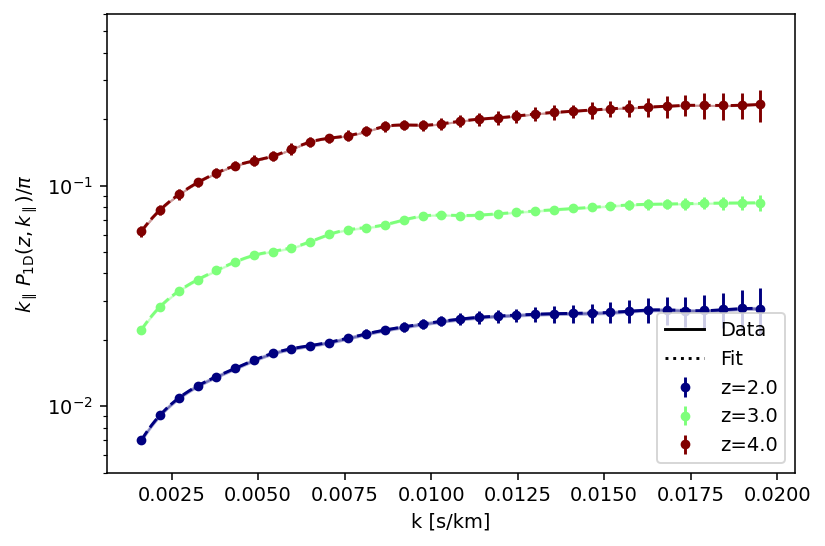

In [25]:
like.plot_p1d(plot_every_iz=4,values=m.values)